In [ ]:
#@title Mount your Google Drive
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/fakenews_data"
!ln -Ts "$folder" /content/news_data 2> /dev/null

if '/content/news_data' not in sys.path:
  sys.path.insert(0, '/content/news_data')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

<ipython-input-2-81e0a356d7ed>:16: UserWarning: CUDA is not available.
  warnings.warn('CUDA is not available.')


In [3]:
!ls /content/news_data/

 all_comments.tsv	     df_comments_sample_10k.tsv   glove.6B.50d.txt
 all_test_public.tsv	     df_posts.tsv		  multimodal_eval_20k.tsv
 all_train.tsv		     df_sample_10k.tsv		  multimodal_test_public.tsv
 all_validate.tsv	    'glove (1).6B.100d.txt'	  multimodal_train_80k.tsv
 com1_model_10k.weights.h5   glove.6B.100d.txt		  multimodal_train.tsv
 com_model_10k.h5	     glove.6B.200d.txt		  multimodal_validate.tsv


## 1. Install packages and Load data

In [4]:
# Install packages
import subprocess

packages = [
    "gdown",
    "textblob",
    "NRCLex==3.0.0",
    "autocorrect==1.1.0",
    "contractions",
    "unidecode",
    "emoji",
    "nltk",
    "scikit-learn",
    "tensorflow"
]

subprocess.run("pip install --upgrade pip setuptools -q", shell=True)

for package in packages:
    try:
        print(f"Installing {package}...")
        subprocess.run(f"pip install -q {package}", shell=True, check=True)
        print(f"{package} installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package}: {e}")

Installing gdown...
gdown installed successfully.
Installing textblob...
textblob installed successfully.
Installing NRCLex==3.0.0...
NRCLex==3.0.0 installed successfully.
Installing autocorrect==1.1.0...
autocorrect==1.1.0 installed successfully.
Installing contractions...
contractions installed successfully.
Installing unidecode...
unidecode installed successfully.
Installing emoji...
emoji installed successfully.
Installing nltk...
nltk installed successfully.
Installing scikit-learn...
scikit-learn installed successfully.
Installing tensorflow...
tensorflow installed successfully.


In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd

# Load train, validation, and test data (TSV files)
df_train = pd.read_csv('/content/news_data/multimodal_train.tsv', sep='\t', on_bad_lines='skip')
df_val   = pd.read_csv('/content/news_data/multimodal_validate.tsv', sep='\t', on_bad_lines='skip')
df_test  = pd.read_csv('/content/news_data/multimodal_test_public.tsv', sep='\t', on_bad_lines='skip')

df_posts = pd.concat([df_train, df_val, df_test], ignore_index=True)
print("Total posts loaded:", len(df_posts))

Total posts loaded: 682661


In [ ]:
import pandas as pd

# Load train, validation, and test data (TSV files)
# df_train = pd.read_csv('/content/news_data/multimodal_train_80k.tsv', sep='\t', on_bad_lines='skip')
# df_val   = pd.read_csv('/content/news_data/multimodal_eval_20k.tsv', sep='\t', on_bad_lines='skip')
# df_test  = pd.read_csv('/content/news_data/multimodal_test_public.tsv', sep='\t', on_bad_lines='skip')

df_posts = pd.concat([df_train, df_val], ignore_index=True)
print("Total posts loaded:", len(df_posts))

Total posts loaded: 100000


In [10]:
# Load comments data
df_comments = pd.read_csv('/content/news_data/all_comments.tsv', sep='\t', on_bad_lines='skip')
print("Total comments loaded:", len(df_comments))
# Peek at columns
print("Post columns:", df_posts.columns.tolist())
print("Comment columns:", df_comments.columns.tolist())

<ipython-input-10-3f90edd025b9>:2: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('/content/news_data/all_comments.tsv', sep='\t', on_bad_lines='skip')


Total comments loaded: 10697533
Post columns: ['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url', 'linked_submission_id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label']
Comment columns: ['Unnamed: 0', 'id', 'author', 'body', 'isTopLevel', 'parent_id', 'submission_id', 'ups']


In [9]:
df_posts['2_way_label'].mean()

np.float64(0.5)

## 2. Data pre-processing

In [ ]:
# Remove posts with missing or empty titles
df_posts = df_posts.dropna(subset=['clean_title'])
print(len(df_posts))
df_posts = df_posts[df_posts['clean_title'].str.strip().astype(bool)]
print(len(df_posts))

df_posts = df_posts.dropna(subset=['2_way_label'])
print(len(df_posts))

df_posts['2_way_label'] = df_posts['2_way_label'].astype(int)
print(len(df_posts))

100000
100000
100000
100000


In [ ]:

# post_ids_with_comments = set(df_comments['submission_id'].unique())
# df_posts = df_posts[df_posts['id'].isin(post_ids_with_comments)]
print(len(df_posts))
# Drop duplicate titles if any (to remove duplicate news)
# df_posts = df_posts.drop_duplicates(subset=['clean_title'])

print("Filtered posts count:", len(df_posts))
print("Fake news count:", sum(df_posts['2_way_label'] == 1))
print("Real news count:", sum(df_posts['2_way_label'] == 0))

100000
Filtered posts count: 100000
Fake news count: 50000
Real news count: 50000


## 3. Text pre-processing

In [ ]:
# Remove HTML tags and URLs.
# Normalize accented characters (e.g., “café” -> “cafe”).
# Expand contractions (e.g., "can't" -> "cannot").
# Convert emojis to text (e.g., 😢 -> ":crying_face:" -> "crying face").
# Remove special characters (keeping only letters, numbers, whitespace, and ! and ? as they may carry sentiment).
# Fix spelling of words (using autocorrect).
# Remove stopwords (common words like “the”, “and”).
# Trim extra whitespace.

In [ ]:
import re
import string
from autocorrect import Speller
from unidecode import unidecode
import emoji
import contractions
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

spell = Speller(lang='en')
stop_words = set(stopwords.words('english'))

punct_to_keep = "!?";

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = contractions.fix(text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = unidecode(text)
    text = text.replace(":", " ")
    text = text.replace("_", " ")
    text = re.sub(f"[^{re.escape(string.ascii_letters + string.digits + string.whitespace + punct_to_keep)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    corrected_words = []
    for word in text.split():
        if word not in punct_to_keep:
            corrected = spell(word)
        else:
            corrected = word
        corrected_words.append(corrected)
    text = ' '.join(corrected_words)
    text = ' '.join(w for w in text.split() if w not in stop_words)
    text = text.strip()
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Test cases
test_cases = [
    "Great!!! This isn't a <b>drill</b> 😱. https://example.com now.",
    "great !!! drill 😱",
    "Happy 😊 day",
    "Sad 😢 tears",
    "Café 😍 time"  # Test with accented characters
]

for test in test_cases:
    print("Original:", test)
    print("Cleaned: ", clean_text(test))
    print()

Original: Great!!! This isn't a <b>drill</b> 😱. https://example.com now.
Cleaned:  great!!! drill face screaming fear

Original: great !!! drill 😱
Cleaned:  great !!! drill face screaming fear

Original: Happy 😊 day
Cleaned:  happy smiling face smiling eyes day

Original: Sad 😢 tears
Cleaned:  sad crying face tears

Original: Café 😍 time
Cleaned:  cafe smiling face heart eyes time



## 4. Sentiment Analysis of Titles

In [ ]:
from textblob import TextBlob
from tqdm import tqdm

tqdm.pandas()
# df_posts['title_cleaned'] = df_posts['clean_title'].apply(clean_text)
df_posts['title_cleaned'] = df_posts['clean_title'].progress_apply(clean_text)

# df_posts['sentiment_score'] = df_posts['title_cleaned'].apply(lambda txt: TextBlob(txt).sentiment.polarity)

# print(df_posts[['clean_title', 'title_cleaned', 'sentiment_score']].head(5))

# the result ranges from -1.0 (very negative) to +1.0 (very positive), with 0 being neutral.

100%|██████████| 100000/100000 [1:01:26<00:00, 27.13it/s]


In [27]:
df_posts['sentiment_score'] = df_posts['title_cleaned'].apply(lambda txt: TextBlob(txt).sentiment.polarity)

In [28]:
print(df_posts[['clean_title', 'title_cleaned', 'sentiment_score']].head(5))

                                         clean_title  \
0      irs spent to make parody of trumps apprentice   
1                    this cloud casting a big shadow   
2  my poor positioning and the fact that the sky ...   
3                    poop hot seller at disney world   
4  gov chris christie at the stroke of midnight f...   

                                       title_cleaned  sentiment_score  
0            irs spent make parody trumps apprentice        -0.100000  
1                           cloud casting big shadow         0.000000  
2  poor positioning fact sky included reason see ...        -0.400000  
3                       poop hot seller disney world         0.250000  
4  gov chris christie stroke midnight friday orde...        -0.075758  


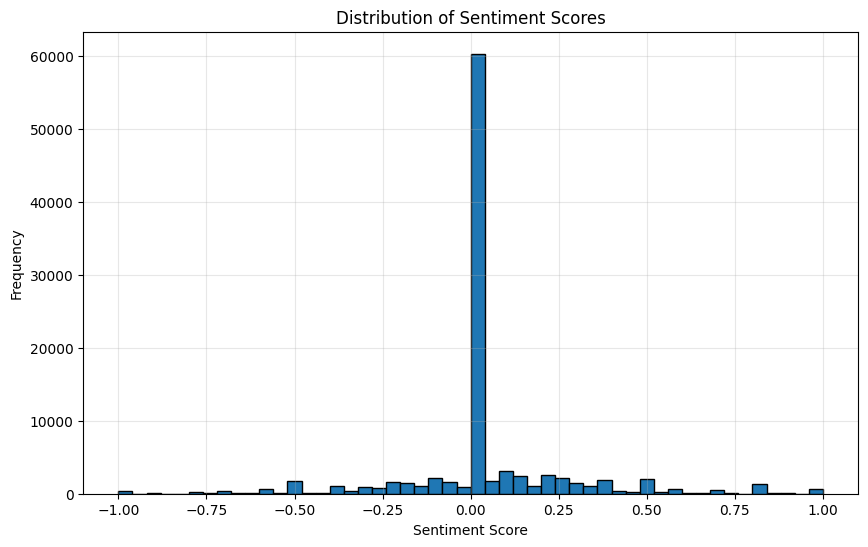

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_posts['sentiment_score'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
df_posts.shape

(100000, 18)

In [ ]:
# Define the target directory
output_dir = '/content/gdrive/MyDrive/fakenews_data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

# Save DataFrame to TSV
output_path = os.path.join(output_dir, 'df_posts_100k.tsv')
df_posts.to_csv(output_path, sep='\t', index=False)
print(f"DataFrame saved to {output_path}")

print("File exists:", os.path.exists(output_path))

Directory already exists: /content/gdrive/MyDrive/fakenews_data
DataFrame saved to /content/gdrive/MyDrive/fakenews_data/df_posts_100k.tsv
File exists: True


In [ ]:
df_sample = pd.read_csv('/content/news_data/df_sample_10k.tsv', sep='\t', on_bad_lines='skip')

In [32]:
df_sample = df_posts.sample(n=100000, random_state=42)

In [33]:
df_sample

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,title_cleaned,sentiment_score
75721,pantsineedthem,a man contorting in midair the seat of his pan...,1.456696e+09,i.imgur.com,True,485yed,https://external-preview.redd.it/9jWNwXeDbomcC...,NaN,9.0,22,photoshopbattles,"PsBattle: a man contorting in mid-air, the sea...",0.69,1,0,0,man contorting midair seat pants midrib,0.000000
80184,Child-Connoisseur,does this count,1.550431e+09,i.redd.it,True,arnszc,https://preview.redd.it/9bckiseng6h21.jpg?widt...,NaN,3.0,11,confusing_perspective,Does this count?,0.64,0,2,2,count,0.000000
19864,Inaerius,this business charges you a fee if you pay by ...,1.564005e+09,imgur.com,True,cheoxt,https://external-preview.redd.it/21wLmegVt9RZC...,NaN,6.0,15,mildlyinteresting,This business charges you a fee if you pay by ...,0.87,1,0,0,business charges fee pay cash rather card,0.000000
76699,anitachance,hidden homos and how to spot them usa,1.510846e+09,imgur.com,True,7dd3hs,https://external-preview.redd.it/EfabT08QQ1Y-o...,NaN,83.0,751,propagandaposters,"“Hidden Homos and How to Spot Them!” USA, 1962",0.97,0,1,5,hidden homos spot usa,-0.166667
92991,hey_watti,this pic of london looks like it should be a v...,1.555680e+09,i.redd.it,True,bez2hw,https://preview.redd.it/6etr3pms28t21.jpg?widt...,NaN,1197.0,77744,mildlyinteresting,This pic of London looks like it should be a v...,0.92,1,0,0,pic london looks like video,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,gifs_SS,hands up its a choice watch the dude in the de...,1.501448e+09,i.imgur.com,True,6qjuqb,https://external-preview.redd.it/15hr2mjzyG4IC...,NaN,20.0,6,subredditsimulator,"Hands up, its a choice ! Watch the dude in the...",0.75,0,2,3,hands choice watch dude degree corner sun,0.000000
54886,AbsoluteZero1111,they both share an arm sorry for the poor phot...,1.563972e+09,i.redd.it,True,ch7nx9,https://preview.redd.it/1jivzxb3y8c31.jpg?widt...,NaN,0.0,34,confusing_perspective,They both share an arm. (Sorry for the poor ph...,0.88,0,2,2,share arm sorry poor photo quality,-0.450000
76820,kingsigma,can you see whats wrong with this bikini astou...,1.492836e+09,archive.is,True,66u7ab,https://external-preview.redd.it/zalUNtsBwmjtw...,NaN,13.0,188,savedyouaclick,Can YOU see what’s wrong with this bikini? Ast...,0.93,0,2,5,see wrong bikini astounding secret behind woma...,-0.140000
860,alborz27,what happens when you put a speaker in a huge ...,1.485814e+09,streamable.com,True,5r3xf1,https://external-preview.redd.it/OYbfCIPjzVp8W...,NaN,1.0,31,savedyouaclick,What Happens When You Put A Speaker In A Huge ...,0.84,0,2,5,happens put speaker huge vacuum chamber hear,0.195833


## 5. Emotion Analysis of Comments

In [ ]:
# Novelty group: emotions of fear, disgust, and surprise (we also include anger in this group, as it was presumably intended​).
# Expectation group: emotions of anticipation, sadness, joy, and trust​
# Neutral group: applies if the comment’s emotions are balanced (i.e., the summed scores for novelty vs. expectation emotions are equal)​

In [ ]:
from nrclex import NRCLex

# Classify a single comment into Novelty / Expectation / Neutral
def classify_comment_emotion(comment_text: str) -> str:
    text = clean_text(comment_text)
    if not text:
        return "neutral" 
    emotion = NRCLex(text)
    scores = emotion.raw_emotion_scores  

    novelty_score = scores.get('anger', 0) + scores.get('fear', 0) + scores.get('disgust', 0) + scores.get('surprise', 0)
    expect_score = scores.get('anticipation', 0) + scores.get('sadness', 0) + scores.get('joy', 0) + scores.get('trust', 0)

    if novelty_score > expect_score:
        return "novelty"
    elif expect_score > novelty_score:
        return "expectation"
    else:
        return "neutral"

In [ ]:
df_comments_sample = df_comments[df_comments['submission_id'].isin(df_sample['id'])].copy()
print("Sample Comments for filtered posts:", len(df_comments_sample))

Sample Comments for filtered posts: 1627529


In [36]:
df_comments_sample

,Unnamed: 0,id,author,body,isTopLevel,parent_id,submission_id,ups
24401,25446,f3oi6l9,EPICJAYSON12,This is a very wholesome gif,True,t3_dhiuq5,dhiuq5,1.0
24402,25447,f3vd0i0,cpcallen,I love the fact that the title describes both ...,True,t3_dhiuq5,dhiuq5,1.0
24534,25579,f3etn1u,KingOrion77,Who use the term “Stroking my dog”?,True,t3_dgs5id,dgs5id,55.0
24535,25580,f3ess08,Pototsky,It is in us and around us. This whole place is...,True,t3_dgs5id,dgs5id,15.0
24536,25581,f3f5lmk,davidforslunds,*Uzumaki intensifies*,True,t3_dgs5id,dgs5id,9.0
...,...,...,...,...,...,...,...,...
10697507,10601559,c4qqpz9,Jakuu21,This type of impact people choose to have on e...,True,t3_ty2wq,ty2wq,3.0
10697508,10601560,c4qr9f7,mcknazzy,I'm bawlin ovah heah!,True,t3_ty2wq,ty2wq,3.0
10697509,10601561,c4qv43z,cinza,"Doesn't it look a bit fake? I mean, there was ...",True,t3_ty2wq,ty2wq,1.0
10697510,10601562,c4r0kt0,razorsheldon,I don't think anybody could fake his reaction ...,False,t1_c4qv43z,ty2wq,2.0


In [ ]:
import re
import string
from unidecode import unidecode
import emoji
import contractions
import pandas as pd
from joblib import Parallel, delayed
import time

punct_to_keep = "!?"
html_pattern = re.compile(r'<.*?>')
url_pattern = re.compile(r'http\S+|www\.\S+')
special_char_pattern = re.compile(f"[^{re.escape(string.ascii_letters + string.digits + string.whitespace + punct_to_keep)}]")
whitespace_pattern = re.compile(r'\s+')

def clean_text_comment(text) -> str:
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    text = text.lower()
    text = html_pattern.sub(' ', text)
    text = url_pattern.sub(' ', text)
    text = contractions.fix(text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = unidecode(text)
    text = text.replace(":", " ").replace("_", " ")
    text = special_char_pattern.sub(' ', text)
    text = whitespace_pattern.sub(' ', text).strip()
    return text

def parallel_clean(df, column_name):
    return Parallel(n_jobs=-1)(delayed(clean_text_comment)(text) for text in df[column_name])

test = "I'm from KY, and just happy to see a nice stor"
print("Original:", test)
print("Cleaned: ", clean_text_comment(test))

Original: I'm from KY, and just happy to see a nice stor
Cleaned:  i am from ky and just happy to see a nice stor


In [38]:
start_time = time.time()

df_comments_sample['body'] = df_comments_sample['body'].astype(str).fillna('')

df_comments_sample['comment'] = parallel_clean(df_comments_sample, 'body')

end_time = time.time()
print(f"Cleaning took {end_time - start_time:.2f} seconds")

print(df_comments_sample.head())

Cleaning took 287.25 seconds
      Unnamed: 0       id          author  \
24401      25446  f3oi6l9    EPICJAYSON12   
24402      25447  f3vd0i0        cpcallen   
24534      25579  f3etn1u     KingOrion77   
24535      25580  f3ess08        Pototsky   
24536      25581  f3f5lmk  davidforslunds   

                                                    body isTopLevel  \
24401                       This is a very wholesome gif       True   
24402  I love the fact that the title describes both ...       True   
24534                Who use the term “Stroking my dog”?       True   
24535  It is in us and around us. This whole place is...       True   
24536                              *Uzumaki intensifies*       True   

       parent_id submission_id   ups  \
24401  t3_dhiuq5        dhiuq5   1.0   
24402  t3_dhiuq5        dhiuq5   1.0   
24534  t3_dgs5id        dgs5id  55.0   
24535  t3_dgs5id        dgs5id  15.0   
24536  t3_dgs5id        dgs5id   9.0   

                                

In [39]:
from joblib import Parallel, delayed
from tqdm import tqdm
import time

# parallel
def parallel_classify(df, column_name):
    # process
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(classify_comment_emotion)(text) for text in tqdm(df[column_name], desc="Classifying emotions")
    )
    return results

In [40]:
import nltk

nltk.download('punkt_tab', quiet=True)

True

In [ ]:
## Time comsuming problem, If you are good at optimizing, please optimize it.
from nrclex import NRCLex

# Classify a single comment into Novelty / Expectation / Neutral
def classify_comment_emotion(comment_text: str) -> str:
    text = clean_text(comment_text)
    if not text:
        return "neutral" 
    emotion = NRCLex(text)
    scores = emotion.raw_emotion_scores  

    novelty_score = scores.get('anger', 0) + scores.get('fear', 0) + scores.get('disgust', 0) + scores.get('surprise', 0)
    expect_score = scores.get('anticipation', 0) + scores.get('sadness', 0) + scores.get('joy', 0) + scores.get('trust', 0)

    if novelty_score > expect_score:
        return "novelty"
    elif expect_score > novelty_score:
        return "expectation"
    else:
        return "neutral"
    
from joblib import Parallel, delayed
from tqdm import tqdm
import time

# parallel
def parallel_classify(df, column_name):
    # process
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(classify_comment_emotion)(text) for text in tqdm(df[column_name], desc="Classifying emotions")
    )
    return results

# over 100 hours in 4 kernel CPU
start = time.time()
df_comments_sample['emotion_group'] = parallel_classify(df_comments_sample, 'comment')
print(f"Time for 100k rows: {time.time() - start:.2f} seconds")

In [ ]:
start = time.time()
df_comments_sample['emotion_group'] = parallel_classify(df_comments_sample, 'comment')
print(f"Time for 100k rows: {time.time() - start:.2f} seconds")


# Define the target directory
output_dir = '/content/gdrive/MyDrive/fakenews_data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

output_path = os.path.join(output_dir, 'df_comments_sample_100k.tsv')
df_comments_sample.to_csv(output_path, sep='\t', index=False)
print(f"DataFrame saved to {output_path}")

print("File exists:", os.path.exists(output_path))

Classifying emotions:   0%|          | 262/1627529 [01:45<174:51:32,  2.59it/s]

KeyboardInterrupt: 

In [ ]:
# # Define the target directory
# output_dir = '/content/gdrive/MyDrive/fakenews_data'

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created directory: {output_dir}")
# else:
#     print(f"Directory already exists: {output_dir}")

# # Save DataFrame to TSV
# output_path = os.path.join(output_dir, 'df_sample_10k.tsv')
# df_sample.to_csv(output_path, sep='\t', index=False)
# print(f"DataFrame saved to {output_path}")

# # Verify file existence
# print("File exists:", os.path.exists(output_path))

Directory already exists: /content/gdrive/MyDrive/fakenews_data
DataFrame saved to /content/gdrive/MyDrive/fakenews_data/df_sample_10k.tsv
File exists: True


In [ ]:
df_sample.shape

(10000, 18)

In [ ]:
df_comments_sample

,Unnamed: 0,id,author,body,isTopLevel,parent_id,submission_id,ups,comment,emotion_group
401,436,f1fnrji,Gamer-_-Bro,Smart move by Trump,True,t3_d98j4z,d98j4z,71.0,smart move by trump,novelty
402,437,f1ftgez,BigRedCowboy,The one thing Dems said he wasn’t brave enough...,True,t3_d98j4z,d98j4z,25.0,the one thing dems said he was not brave enoug...,neutral
403,438,f1fpgzd,Dipstu,This’ll show Pelosi what’s what !,True,t3_d98j4z,d98j4z,16.0,this will show pelosi what is what !,expectation
404,439,f1fqjsp,FatherOfTheState,When Eric Trump can't even be trusted to bury ...,True,t3_d98j4z,d98j4z,13.0,when eric trump cannot even be trusted to bury...,neutral
405,440,f1ilrt0,IdahoSavage,I wish,True,t3_d98j4z,d98j4z,1.0,i wish,neutral
...,...,...,...,...,...,...,...,...,...,...
10696128,10599571,c5gl6si,2425brutus,I read this a little while ago but just found ...,True,t3_wuo4e,wuo4e,2.0,i read this a little while ago but just found ...,expectation
10696129,10599572,c5gmj41,wibblebeast,He was a fine person and I'm so sad to hear th...,True,t3_wuo4e,wuo4e,2.0,he was a fine person and i am so sad to hear t...,neutral
10696130,10599573,c5gli5f,timdaw,Thanks. That was lovely.,False,t1_c5gl6si,wuo4e,2.0,thanks that was lovely,expectation
10696663,10600141,c58b5n6,wibblebeast,When they all stood up I got all teary. So nic...,True,t3_vw2qs,vw2qs,5.0,when they all stood up i got all teary so nice...,expectation


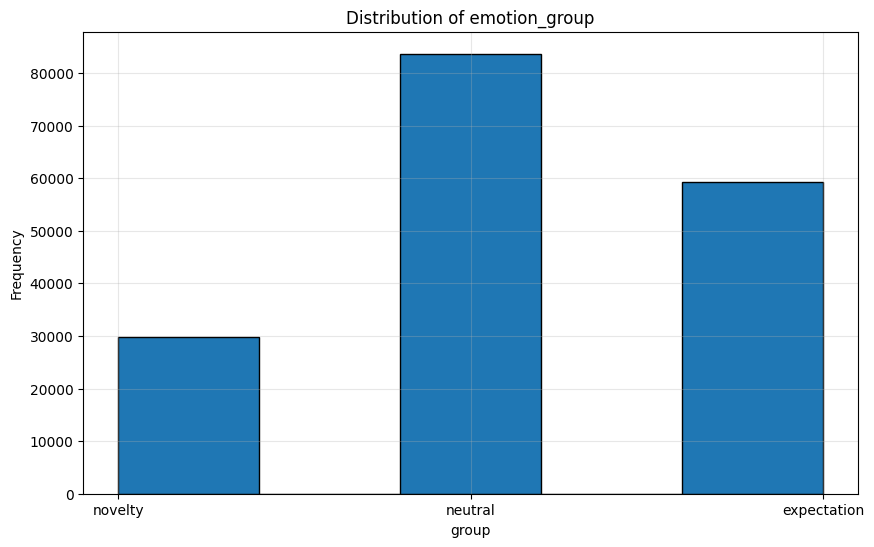

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_comments_sample['emotion_group'].dropna(), bins=5, edgecolor='black')
plt.title('Distribution of emotion_group')
plt.xlabel('group')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
group_counts = df_comments_sample.groupby(['submission_id', 'emotion_group']).size().unstack(fill_value=0)

for grp in ["novelty", "expectation", "neutral"]:
    if grp not in group_counts.columns:
        group_counts[grp] = 0

In [ ]:
def dominant_group_count(row):
    
    nov, exp, neut = row["novelty"], row["expectation"], row["neutral"]
 
    if nov == exp and nov >= neut:
        return "neutral"
    if neut > nov and neut > exp:
        return "neutral"
    if nov > exp and nov >= neut:
        return "novelty"
    if exp > nov and exp >= neut:
        return "expectation"
    # If all equal (rare) or empty, call it neutral
    return "neutral"

In [ ]:
dominant_groups = group_counts.apply(dominant_group_count, axis=1)
# Map group: expectation=0, neutral=0.5, novelty=1
group_to_value = {"expectation": 0.0, "neutral": 0.5, "novelty": 1.0}
emotion_feature = dominant_groups.map(group_to_value)

In [ ]:

df_sample['emotion_score'] = df_sample['id'].map(emotion_feature)
df_sample['emotion_score'].fillna(0.5, inplace=True)  # if any missing (no comments or tie), assign neutral 0.5
print("Sample of emotion feature values:", df_sample[['id','emotion_score']].head(5))

Sample of emotion feature values:        id  emotion_score
0  7nibhe            0.0
1  1rcv6y            0.5
2  5tvvn5            0.0
3  bynpyd            0.5
4  1u0y70            0.5


<ipython-input-30-c003b04d13dd>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sample['emotion_score'].fillna(0.5, inplace=True)  # if any missing (no comments or tie), assign neutral 0.5


In [ ]:
print(df_sample['emotion_score'].value_counts())

emotion_score
0.5    5713
0.0    3498
1.0     789
Name: count, dtype: int64


## 6. Prepare Data for Modeling

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X_text = df_sample['title_cleaned'].astype(str).values  # title text
X_sentiment = df_sample['sentiment_score'].values
X_emotion = df_sample['emotion_score'].values
y = df_sample['2_way_label'].values

In [ ]:
# Split into train and test sets
X_text_train, X_text_test, X_sent_train, X_sent_test, X_emot_train, X_emot_test, y_train, y_test = train_test_split(
    X_text, X_sentiment, X_emotion, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_text_train))
print("Testing samples:", len(X_text_test))

Training samples: 8000
Testing samples: 2000


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

X_seq_train = tokenizer.texts_to_sequences(X_text_train)
X_seq_test  = tokenizer.texts_to_sequences(X_text_test)

max_len = max(len(seq) for seq in X_seq_train)
X_seq_train = pad_sequences(X_seq_train, maxlen=max_len, padding='post')
X_seq_test  = pad_sequences(X_seq_test, maxlen=max_len, padding='post')
print("Max title length:", max_len)
print("Shape of padded train sequences:", X_seq_train.shape)

Vocabulary size: 12796
Max title length: 33
Shape of padded train sequences: (8000, 33)


In [ ]:
# !curl -I http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
import numpy as np
# Load GloVe 100d into memory
embeddings_index = {}
with open('/content/news_data/glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coeffs
print("Total GloVe vectors loaded:", len(embeddings_index))

Total GloVe vectors loaded: 400000


In [ ]:

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue  
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector

## 7. Build the Bi-LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

# define model
title_input = Input(shape=(max_len,), name='title_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                            input_length=max_len, trainable=False)(title_input)
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.005)))(embedding_layer)
x = Dropout(0.6)(x)
x = Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.005)))(x)
x = Dropout(0.6)(x)
text_repr = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)

sent_input = Input(shape=(1,), name='sentiment_input')
sent_dense = Dense(8, activation='relu', kernel_regularizer=l2(0.005))(sent_input)
emot_input = Input(shape=(1,), name='emotion_input')
emot_dense = Dense(8, activation='relu', kernel_regularizer=l2(0.005))(emot_input)

combined = Concatenate()([text_repr, sent_dense, emot_dense])
combined = Dropout(0.6)(combined)
combined = Dense(16, activation='relu', kernel_regularizer=l2(0.005))(combined)
combined = Dropout(0.6)(combined)
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[title_input, sent_input, emot_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)  │ (None, 33)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 33, 100)        │      1,279,600 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_29          │ (None, 33, 128)        │         84,480 │ embedding_16[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_59 (Dropout)      │ (None, 33, 128)        │              0 │ bidirectional_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_30          │ (None, 128)            │         98,816 │ dropout_59[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_60 (Dropout)      │ (None, 128)            │              0 │ bidirectional_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_75 (Dense)          │ (None, 32)             │          4,128 │ dropout_60[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_76 (Dense)          │ (None, 8)              │             16 │ sentiment_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_77 (Dense)          │ (None, 8)              │             16 │ emotion_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 48)             │              0 │ dense_75[0][0],        │
│ (Concatenate)             │                        │                │ dense_76[0][0],        │
│                           │                        │                │ dense_77[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_61 (Dropout)      │ (None, 48)             │              0 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_78 (Dense)          │ (None, 16)             │            784 │ dropout_61[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_62 (Dropout)      │ (None, 16)             │              0 │ dense_78[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_79 (Dense)          │ (None, 1)              │             17 │ dropout_62[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,467,857 (5.60 MB)

 Trainable params: 188,257 (735.38 KB)

 Non-trainable params: 1,279,600 (4.88 MB)

## 8. Train the Model

In [ ]:
# Prepare inputs for training and testing
X_train_inputs = {
    'title_input': X_seq_train,
    'sentiment_input': X_sent_train,
    'emotion_input': X_emot_train
}
X_test_inputs = {
    'title_input': X_seq_test,
    'sentiment_input': X_sent_test,
    'emotion_input': X_emot_test
}

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_sent_train = scaler.fit_transform(X_sent_train.reshape(-1, 1))
X_sent_test = scaler.transform(X_sent_test.reshape(-1, 1))
X_emot_train = scaler.fit_transform(X_emot_train.reshape(-1, 1))
X_emot_test = scaler.transform(X_emot_test.reshape(-1, 1))

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print("Train label distribution:", np.bincount(y_train) / len(y_train))
print("Test label distribution:", np.bincount(y_test) / len(y_test))

Train label distribution: [0.379875 0.620125]
Test label distribution: [0.38 0.62]


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train
history = model.fit(X_train_inputs, y_train,
                    validation_data=(X_test_inputs, y_test),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5365 - auc: 0.5058 - loss: 3.3908 - val_accuracy: 0.6200 - val_auc: 0.6519 - val_loss: 1.6566 - learning_rate: 5.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6082 - auc: 0.5872 - loss: 1.4250 - val_accuracy: 0.6615 - val_auc: 0.7019 - val_loss: 0.9507 - learning_rate: 5.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6677 - auc: 0.6933 - loss: 0.8913 - val_accuracy: 0.6730 - val_auc: 0.7183 - val_loss: 0.7651 - learning_rate: 5.0000e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6856 - auc: 0.6933 - loss: 0.7494 - val_accuracy: 0.6940 - val_auc: 0.7237 - val_loss: 0.6959 - learning_rate: 5.0000e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7000 - auc: 0.7195 - loss: 0.6869 - val_accuracy: 0.6970 - val_auc: 0.7290 - val_loss: 0.6563 - learning_rate: 5.0000e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - 

## 9. Evaluate the Model

In [ ]:
# Evaluate on test set
loss, accuracy, auc = model.evaluate(X_test_inputs, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# compute AUC
y_pred_prob = model.predict(X_test_inputs)
from sklearn.metrics import roc_auc_score, accuracy_score
auc_manual = roc_auc_score(y_test, y_pred_prob)
acc_manual = accuracy_score(y_test, (y_pred_prob >= 0.5).astype(int))
print(f"Manual Accuracy: {acc_manual:.4f}")
print(f"Manual AUC: {auc_manual:.4f}")


Test Accuracy: 0.6980
Test AUC: 0.7437
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Manual Accuracy: 0.6980
Manual AUC: 0.7437


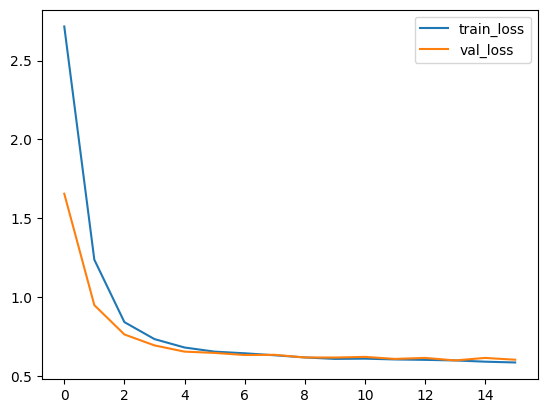

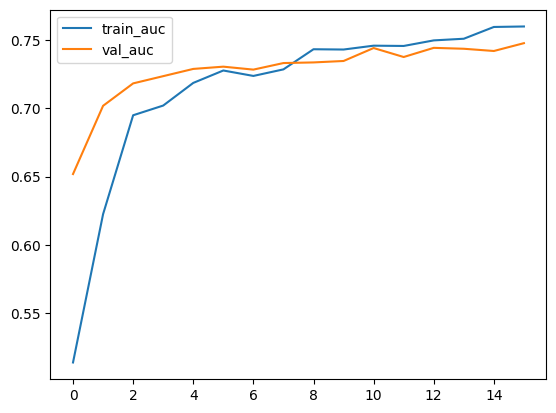

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend()
plt.show()

In [ ]:
print("Training loss:", history.history['loss'])
print("Validation loss:", history.history['val_loss'])
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])
print("Training AUC:", history.history['auc'])
print("Validation AUC:", history.history['val_auc'])

Training loss: [2.7158656120300293, 1.2387604713439941, 0.8432790040969849, 0.7357571125030518, 0.6824769377708435, 0.6562443375587463, 0.6458036303520203, 0.6331867575645447, 0.619497537612915, 0.6102486252784729, 0.6117549538612366, 0.6068024635314941, 0.6041766405105591, 0.6004887819290161, 0.5926637053489685, 0.5875850319862366]
Validation loss: [1.6566160917282104, 0.9507350325584412, 0.7651288509368896, 0.6958505511283875, 0.656277596950531, 0.648239016532898, 0.634865939617157, 0.6360563635826111, 0.619369387626648, 0.6189076900482178, 0.6229953765869141, 0.6101675033569336, 0.616587221622467, 0.6006053686141968, 0.6163960695266724, 0.6050150394439697]
Training accuracy: [0.5648750066757202, 0.6211249828338623, 0.6746249794960022, 0.6863750219345093, 0.6980000138282776, 0.7052500247955322, 0.7007499933242798, 0.703249990940094, 0.7101250290870667, 0.7106249928474426, 0.7096250057220459, 0.7105000019073486, 0.7228749990463257, 0.7206249833106995, 0.718375027179718, 0.722874999046

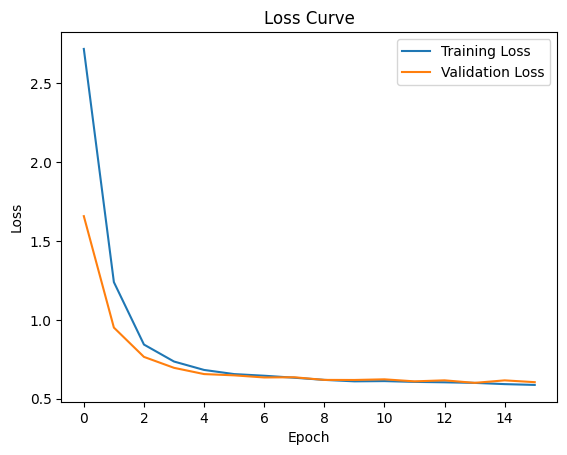

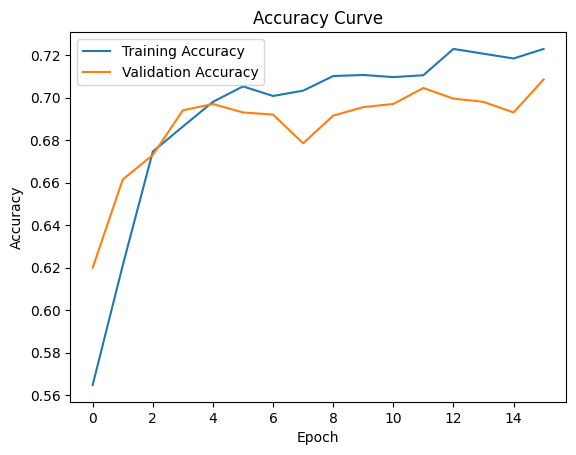

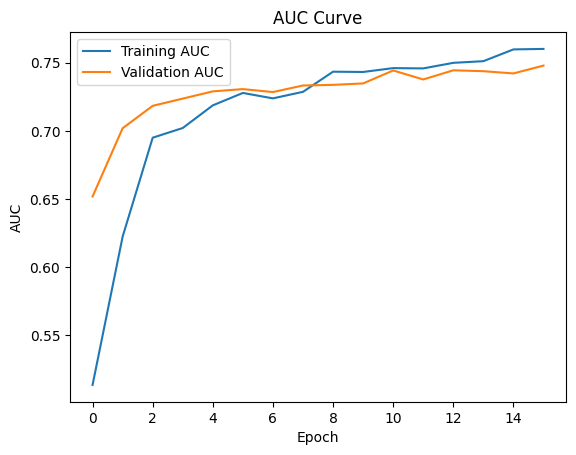

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Curve')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [ ]:
# Define the target directory
output_dir = '/content/gdrive/MyDrive/fakenews_data'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")
else:
    print(f"Directory already exists: {output_dir}")

output_path = os.path.join(output_dir, 'com_model_10k.h5')
model.save(output_path)

weight_path = os.path.join(output_dir, 'com1_model_10k.weights.h5')
model.save_weights(weight_path)

print(f"model saved to {output_path}")

print("File exists:", os.path.exists(output_path))

print(f"model saved to {weight_path}")

print("File exists:", os.path.exists(weight_path))

Directory already exists: /content/gdrive/MyDrive/fakenews_data
model saved to /content/gdrive/MyDrive/fakenews_data/com_model_10k.h5
File exists: True
model saved to /content/gdrive/MyDrive/fakenews_data/com1_model_10k.weights.h5
File exists: True


In [ ]:
loaded_model = tf.keras.models.load_model(output_path)
loaded_model.evaluate(X_test_inputs, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6832 - auc: 0.7209 - loss: 0.6188


[0.6006053686141968, 0.6980000138282776, 0.7437499761581421]